In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [115]:
dataset = pd.read_csv('ratings.csv')
dataset['movieId'].nunique()

9066

In [116]:
dataset.head(4)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185


In [117]:
sparsity = dataset.shape[0]/(dataset['movieId'].nunique() * dataset['userId'].nunique())

In [118]:
print(sparsity)

0.016439141608663475


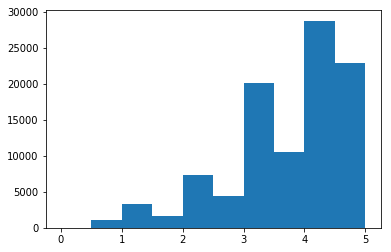

In [119]:
plt.hist(dataset['rating'],bins=np.arange(0, 5 + 0.5, 0.5))
plt.show()

In [120]:
from collections import Counter
movie_ids = dataset['movieId']
#Counter(movie_ids)

In [121]:
movie_ratings_dict = dict(Counter(movie_ids))

In [122]:
plt.plot(range(0,len(movie_ratings_dict.keys())), sorted(movie_ratings_dict.values(),reverse=True))

In [123]:
user_ids = dataset['userId']

In [124]:
user_ratings_dict = dict(Counter(user_ids))

In [125]:
plt.plot(range(0,len(user_ratings_dict.keys())), sorted(user_ratings_dict.values(),reverse=True))

In [126]:
sum(sorted(user_ratings_dict.values(),reverse=True)[:100])

55141

In [127]:
id_var = (dataset[['movieId','rating']].groupby('movieId',as_index=False)).var().fillna(0)


In [128]:
id_var_dict = dict(zip(list(id_var['movieId']), id_var['rating']))


In [129]:
var_list = list(dataset[['movieId','rating']].groupby('movieId').var()['rating'])

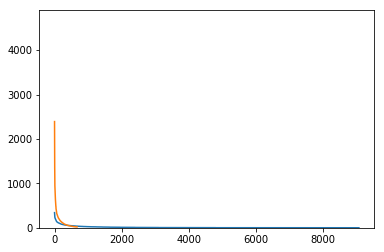

In [130]:
plt.hist(np.nan_to_num(var_list),bins=np.arange(min(var_list), max(var_list), 0.5))
plt.show()


In [164]:
def get_popular(movie_ratings_dict, testset):
    movieids = [x[0] for x in movie_ratings_dict.items() if x[1]>2]
    return [x for x in testset if x[1] in movie_ids]
def get_unpopular(movie_ratings_dict, testset):
    movieids = [x[0] for x in movie_ratings_dict.items() if x[1]<=2]
    return [x for x in testset if x[1] in movie_ids]

def get_highvar(movie_ratings_dict, var_dict, testset):
    movieids = [x[0] for x in movie_ratings_dict.items() if x[1]>=5]
    movieids = [x for x in high_variance_movieids if var_dict[x]>=2 ]
    return [x for x in testset if x[1] in movie_ids]
    

### Question 10 - 14

#### Takes 15-20 min

In [133]:
from surprise import SVD

In [134]:
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
from surprise import Dataset
from surprise import accuracy
from surprise import Reader


In [165]:
def do_kFold(data_, range_,trimm,movie_ratings_dict,splits=10, id_var_dict=None):
    sim_options = {'name': 'pearson_baseline'}
    kf = KFold(n_splits=splits)
    reader = Reader(rating_scale=(1, 5))
    mae_d={}
    rmse_d={}
    for neigh in range_:
        print('Neighbors ',neigh)
        knn_model = KNNWithMeans( k=neigh, sim_options= sim_options)
        rmse_list=[]
        mae_list =[]
        for trainset, testset in kf.split(data_):
            #print(testset)
            if(trimm=='p'):
                testset = get_popular(movie_ratings_dict,testset)
            elif(trimm=='up'):
                testset = get_unpopular(movie_ratings_dict,testset)
            elif(trimm=='hv'):
                testset = get_highvar(movie_ratings_dict,testset)
            knn_model.fit(trainset)
            predictions = knn_model.test(testset,verbose=False)
            rmse_list.append(accuracy.rmse(predictions,verbose=False))
            mae_list.append(accuracy.mae(predictions,verbose=False))
        rmse_d[neigh]=sum(rmse_list)/len(rmse_list)
        mae_d[neigh]=sum(mae_list)/len(mae_list)
        print('Mean rmse',sum(rmse_list)/len(rmse_list))
        print('Mean mae',sum(mae_list)/len(mae_list))
    return rmse_d, mae_d



In [166]:
def rmse_mae_plot(rmse_d,mae_d):
    plt.plot(rmse_d.keys(),rmse_d.values())
    plt.show()
    plt.plot(mae_d.keys(),mae_d.values())
    plt.show()

In [167]:
total_data = Dataset.load_from_df(dataset[['userId','movieId','rating']], reader)
r_d,m_d = do_kFold(total_data, range(2,101,20),'notrim',movie_ratings_dict)#TODO use 2 instead of 8. 8 is used to compute faster

Neighbors  2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearso

In [ ]:
rmse_mae_plot(r_d,m_d)

### Question 11

 k value =20


 RMSE = 0.9146735

### Question 12,13,14

In [ ]:
rp_d, mp_d = do_kFold(total_data, range(2,101,20),'p',movie_ratings_dict)#TODO use 2 instead of 8. 8 is used to compute faster
rup_d,mup_d =do_kFold(total_data, range(2,101,20),'up',movie_ratings_dict)#TODO use 2 instead of 8. 8 is used to compute faster
rhv_d,mhv_d =do_kFold(total_data, range(2,101,20),'hv',movie_ratings_dict, id_var_dict)#TODO use 2 instead of 8. 8 is used to compute faster

### TODO : Run and plot